In [3]:
pip install qiskit.ignis

  Using cached qiskit_ignis-0.7.1-py3-none-any.whl (198 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

In [12]:

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

ibmqfactory.load_account:WARNING:2022-12-13 14:14:49,745: Credentials are already in use. The existing account in the session will be replaced.


backend used:  ibm_nairobi


In [13]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [14]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [24]:
aer_simulator = Aer.get_backend('aer_simulator')

In [15]:
n = 2

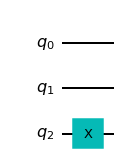

In [16]:
oracle_qc = dj_oracle('constant', n)
oracle_qc.draw()

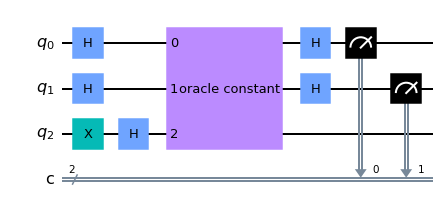

In [17]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

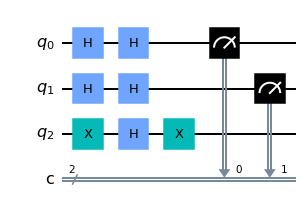

In [18]:
new_dj = dj_circuit.decompose('oracle constant')

new_dj.draw()

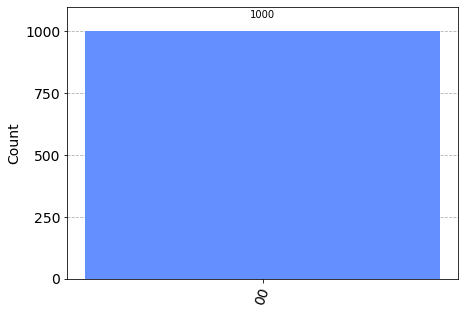

In [19]:
aer_backend = Aer.get_backend('aer_simulator')
job = execute(dj_circuit, aer_backend, shots=1000)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [20]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

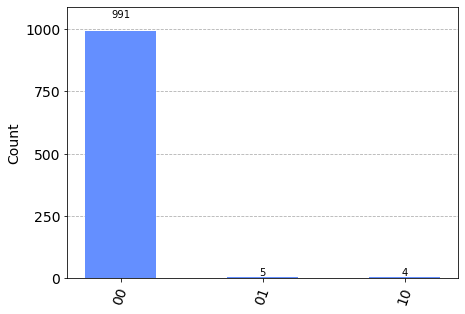

In [20]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [21]:
# QEM
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

Traceback (most recent call last):
  Input In [21] in <cell line: 5>
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
NameError: name 'cal_results' is not defined

Use %tb to get the full traceback.


In [22]:
meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [26]:
cal_results = aer_simulator.run(qem_meas_calibs, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [27]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

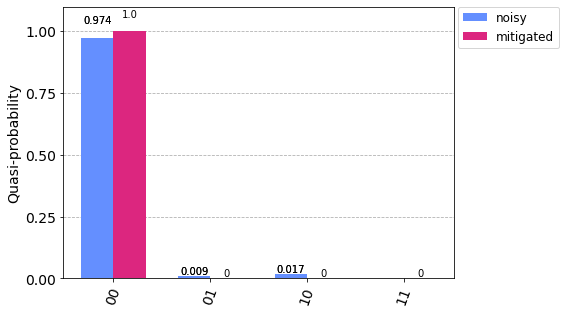

In [28]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [29]:
# GEM

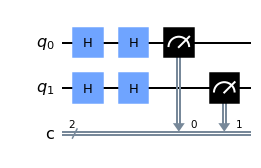

In [30]:
# not calibrating ancilla
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)

dj_left0.h(0)

dj_left0.h(0)

dj_left0.h(1)
dj_left0.h(1)
dj_left0.measure([0,1], [0,1])
dj_left0.draw()

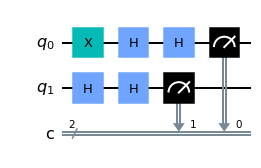

In [31]:
dj_left1 = QuantumCircuit(n, n)
dj_left1.x(0)
dj_left1.h(0)

dj_left1.h(0)
dj_left1.h(1)
dj_left1.h(1)
dj_left1.measure([0,1], [0,1])
dj_left1.draw()

/tmp/ipykernel_116/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


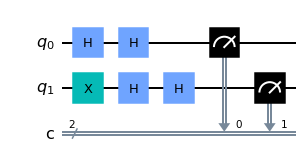

In [32]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_116/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


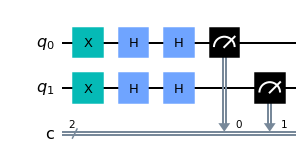

In [33]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

In [34]:
meas_calibs = [dj_left0, dj_left1, dj_left2, dj_left3]

In [35]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)


Circuit circuit-144
     ┌───┐┌───┐┌─┐   
q_0: ┤ H ├┤ H ├┤M├───
     ├───┤├───┤└╥┘┌─┐
q_1: ┤ H ├┤ H ├─╫─┤M├
     └───┘└───┘ ║ └╥┘
c_0: ═══════════╩══╬═
                   ║ 
c_1: ══════════════╩═
                     
Circuit circuit-148
     ┌───┐┌───┐┌───┐┌─┐
q_0: ┤ X ├┤ H ├┤ H ├┤M├
     ├───┤├───┤└┬─┬┘└╥┘
q_1: ┤ H ├┤ H ├─┤M├──╫─
     └───┘└───┘ └╥┘  ║ 
c_0: ════════════╬═══╩═
                 ║     
c_1: ════════════╩═════
                       
Circuit circuit-146
     ┌───┐┌───┐     ┌─┐   
q_0: ┤ H ├┤ H ├─────┤M├───
     ├───┤├───┤┌───┐└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘ ║ └╥┘
c_0: ════════════════╩══╬═
                        ║ 
c_1: ═══════════════════╩═
                          
Circuit circuit-147
     ┌───┐┌───┐┌───┐┌─┐   
q_0: ┤ X ├┤ H ├┤ H ├┤M├───
     ├───┤├───┤├───┤└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘ ║ └╥┘
c_0: ════════════════╩══╬═
                        ║ 
c_1: ═══════════════════╩═
                          


In [37]:
# aer_sim = Aer.get_backend("aer_simulator")
# results = aer_sim.run(meas_calibs, shots=10000).result()
# result_counts = results.get_counts()
# print(result_counts)

[{'00': 10000}, {'01': 10000}, {'10': 10000}, {'11': 10000}]


In [44]:
aer_sim = Aer.get_backend("aer_simulator")
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, shots=10000).result()
result_counts = results.get_counts()
print(result_counts)

[{'00': 10000}, {'01': 10000}, {'10': 10000}, {'11': 10000}]


In [39]:

# meas_calibs = [dj1f, dj2f, dj3f, dj4f]
state_labels = ['00', '01', '10', '11']

In [40]:
# approach 2: make from scratch

In [45]:
t_qc = transpile(meas_calibs, real_backend)
qobj = assemble(t_qc, shots=10000)
real_results = real_backend.run(qobj, shots=10000).result()

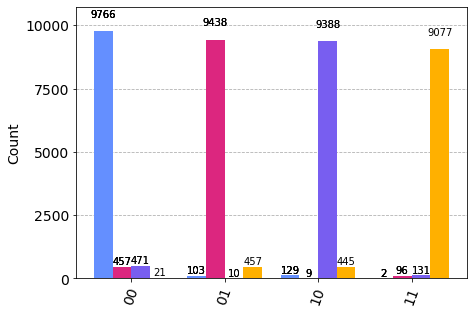

In [46]:
real_counts = real_results.get_counts()
plot_histogram(real_counts)

In [48]:
# result_submissions = job.result()
# array = np.empty((4,4))
# print(array)
ls = []
# array = np.empty(shape=(4,4))
for qc in meas_calibs:
     counts = real_results.get_counts(qc)
     this_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
     # np.append(array, this_array, axis=1)
array = np.array(ls)
# print(array)
array_t = np.transpose(array)
print(array_t)

[9.766e-01 1.030e-02 1.290e-02 2.000e-04]
[4.570e-02 9.438e-01 9.000e-04 9.600e-03]
[0.0471 0.001  0.9388 0.0131]
[0.0021 0.0457 0.0445 0.9077]
[[9.766e-01 4.570e-02 4.710e-02 2.100e-03]
 [1.030e-02 9.438e-01 1.000e-03 4.570e-02]
 [1.290e-02 9.000e-04 9.388e-01 4.450e-02]
 [2.000e-04 9.600e-03 1.310e-02 9.077e-01]]


In [49]:
array_to_latex(array)

<IPython.core.display.Latex object>

In [50]:
import scipy.linalg as la
array_inv = la.inv(array_t)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [51]:
counts = realqc_results.get_counts()

In [52]:
result_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
result_array = result_array/1000

In [53]:
result_array

array([0.974, 0.009, 0.017, 0.   ])

In [54]:
mitigated = np.dot(array_inv, result_array)

In [55]:
array_to_latex(mitigated)

<IPython.core.display.Latex object>

In [56]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [57]:
normal

array([1.        , 0.        , 0.00576683, 0.00107059])

In [ ]:
#Code below is obsolete

In [67]:
# qr = QuantumRegister(n)
# meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# cal_results = real_backend.run(meas_calibs, shots=10000).result()
# meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [68]:
# # Get the filter object
# meas_filter = meas_fitter.filter

# # Results with mitigation
# mitigated_results = meas_filter.apply(realqc_results)
# mitigated_counts = mitigated_results.get_counts()

In [69]:
# mitigated_counts

{'00': 17.4858710855432,
 '01': 101.08848346905096,
 '10': 20.3748802557301,
 '11': 861.0507651896758}

In [ ]:
# def NormalizeData(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))
# NormalizeData(mitigated)
# # https://www.stackvidhya.com/how-to-normalize-data-between-0-and-1-range/

In [46]:
# meas_fitter = CompleteMeasFitter(results, state_labels)
# # , circlabel='mcal'circlabel='circuit
# array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [47]:
# t_qc = transpile(meas_calibs, real_backend)
# qobj = assemble(t_qc, shots=10000)



In [48]:
# results = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_3595/1044830548.py:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  results = real_backend.run(qobj, shots=10000).result()


In [49]:
# result_counts = results.get_counts()
# print(result_counts)

[{'00': 9497, '01': 172, '10': 330, '11': 1}, {'00': 530, '01': 9225, '10': 16, '11': 229}, {'00': 602, '01': 14, '10': 9208, '11': 176}, {'00': 36, '01': 563, '10': 544, '11': 8857}]


In [50]:
# cal_results = real_backend.run(meas_calibs, shots=10000).result()

Traceback (most recent call last):
  Input In [50] in <cell line: 1>
    cal_results = real_backend.run(meas_calibs, shots=10000).result()
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/job/ibmqjob.py:290 in result
    raise IBMQJobFailureError(
IBMQJobFailureError: "Unable to retrieve result for job 6393d5c5ec40c27207f626ef. Job has failed: The Qobj uses gates (['h']) that are not among the basis gates (['id', 'rz', 'sx', 'x', 'cx', 'reset']). Error code: 1106."

Use %tb to get the full traceback.


In [51]:
# cal_results.get_counts()

[{'00': 10000}, {'01': 10000}, {'10': 10000}, {'11': 10000}]

In [52]:
# meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [53]:
# # # Get the filter object
# meas_filter = meas_fitter.filter

# # # Results with mitigation
# # mitigated_results = meas_filter.apply(results)
# # mitigated_counts = mitigated_results.get_counts()

In [ ]:
#fitter would mitigate all results to 0

In [36]:
# approach 1: reuse qiskit EM 
# Refer to https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

In [ ]:
# abandoned approach: create all columns of the calibration matrix from scratch.
# Then abandoned and used approach 2 instead.

In [ ]:
# job = execute(dj_left0, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array0 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array0 = array0/1000
# array0

In [ ]:
# job = execute(dj_left1, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array1 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array1 = array1/1000
# array1

In [ ]:
# job = execute(dj_left2, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array2 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array2 = array2/1000
# array2

In [ ]:
# job = execute(dj_left3, real_backend, shots=1000)
# results = job.result()
# counts = results.get_counts()

In [ ]:
# array3 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
# array3 = array3/1000
# array3

In [ ]:
# array_left = np.array([array0, array1, array2, array3])

In [ ]:
# array_right = array_left

In [ ]:
# calib_mat = (array_left + array_right) / 2

In [ ]:
# array_to_latex(calib_mat)